# Afternoon: Introduction to Spatial Analysis

Now that we've learned the basics of autocorrelation, we're ready to extend the concept to multiple dimensions. We'll see that spatial dimensions are a direct generalization of temporal dimension, and the concept of $lag$ carries over analogously.

First we import the required packages. Again we also have to load the required R packages using `importr`.

In [89]:
#-- Import Required Python Packages
import numpy as np
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
import scipy.spatial
import scipy.linalg

#-- Import R packages in Python
r = robjects.r
nlme = importr('nlme')
stats = importr('stats')

If you don't already have the geoR package for R, you need to install it by running the following cell, which uses the `utils` package to install new packages.

In [ ]:
utils = importr("utils")
utils.install_packages('geoR')

If this doesn't work, it's most likely because you don't have a Fortran compiler. Go to <http://hpc.sourceforge.net>, download the tar.gz file corresponding to your operating system, unpack it (`gunzip <filename>.gz`), and then run `sudo tar -xvf gcc-6.2-bin.tar -C /` in terminal in the same directory as the unpacked file.

Other possible problems: 

- If you get a problem with `gfortran` trying to execute `f951`, find the file:  
    `find /usr/local/ -name f951`  
    and make a hard link for that file, in my case:  
    `sudo ln -s /usr/local//gcc/x86_64-apple-darwin15.6.0/6.3.0/f951 /usr/local/bin/.`  

- If you get the following error:  
    `FATAL:/opt/local/bin/../libexec/as/x86_64/as: I don't understand 'm' flag!`  
    there is a problem with the path of `as`. Simply remove the wrong path your $PATH variable and make sure the right path is included. In the case of Macs, there are two `as` versions, one that comes with the OS and an additional one that comes with Xcode. To use the Xcode version, remove `/opt/local/bin/` from your paths. I temporarily changed my paths to just `/usr/bin:/Users/yaramohajerani/anaconda/bin` by using   
    `export PATH="/usr/bin:/Users/yaramohajerani/anaconda/bin:$PATH"`  
    (Note the default paths will be added if you restart command prompt)

Now we can import `geoR`:

In [2]:
geoR = importr('geoR')

# Simulate spatially correlated data

Here we use an exponential covariance matrix which closely approximates the autoregressive model. We do this because it is more commonly used in software packages for numerical reasons. The approximation is $\alpha \approx e^{-r}$, where $r$ is referred to as the 'decorrleation parameter'.

In [17]:
# two column matrix with all pair-wise coordinates
M = np.array(np.meshgrid(range(1,31), range(1,31))).reshape(2, 30**2).T 
n = len(M)                                              # number of pairs
D_upper_triangle = scipy.spatial.distance.pdist(M)      # Upper triangle distance matrix
D = scipy.spatial.distance.squareform(D_upper_triangle) # convert to square form distance matrix
r0 = 0.1                                                # decorrelation parameter
s = 10                                                  # variance
S = s**2*np.exp(-r0*D)                                  # construct covariance matrix based on distance
L = scipy.linalg.cho_factor(S,lower=True)               # Cholesky factorization of the covariance matrix
Si = scipy.linalg.cho_solve(L,np.eye(S.shape[0]))       # Use factorization to efficiently find S^(-1)
Li = np.linalg.inv(L[0])                                # inverse of lower triangle Cholesky matrix

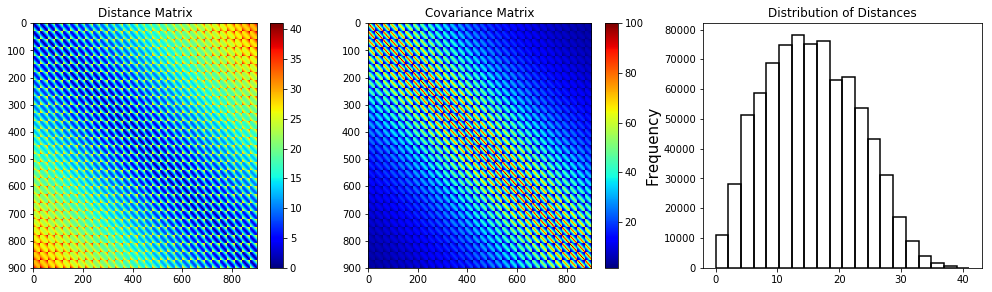

In [18]:
fig, ax = plt.subplots(1,3,figsize=(17,4.5))        # Set up figure and subplots
dist_fig = ax[0].imshow(D,cmap='jet',aspect='auto') # visualize distances
fig.colorbar(dist_fig,ax=ax[0])                     # Add colorbar
ax[0].set_title('Distance Matrix')                  # Add title
corr_fig = ax[1].imshow(S,cmap='jet',aspect='auto') # visualize the covariance matrix
fig.colorbar(corr_fig,ax=ax[1])                     # Add colorbar
ax[1].set_title('Covariance Matrix')                # Add title
ax[2].hist(D.flatten(),20,edgecolor='k',facecolor='none',linewidth=1.5) # make a histogram of the pair-wise distances
ax[2].set_ylabel('Frequency',fontsize=15)           # add y-label
ax[2].set_title('Distribution of Distances')        # add title
plt.show()

** QUESTION FOR US: WHY ARE THERE SMALL SQUARES EACH WITH A DECAYING AUTOCORRELATIO PATTERN? ** 

Apply correlation structure to random data.
Note if $L$ is the lower triangular matrix from the Cholesky decompisition of $S$ such that
\begin{equation}
S=LL^*=L\overline{(L^T)}=L{(\overline{L})}^T = LL^T \text{ if } L \in \mathbb{R}^{n\times n}\\
\text{where } \overline{L} \text{ contains the complex conjugate of the elements of }L
\end{equation}

then the product of random noise and $L$ produces the correlation structure of the original covariance matrix:

Let $x_0$ be a matrix of random uncorrelated values with mean 0 and variance of 1 (i.e. $\mathrm{E}(x_0x_0^T)=I$), and $x = Lx_0$.
Then the covariance matrix of $x$ is 

\begin{equation}
\mathrm{E}(xx^T) = \mathrm{E}((Lx_0)(Lx_0)^T) = \mathrm{E}(Lx_0x_0^TL^T) = L\mathrm{E}(x_0x_0^T)L^T = LIL^T = LL^T = S
\end{equation}

which is the original covariance matrix with the correlation structure.

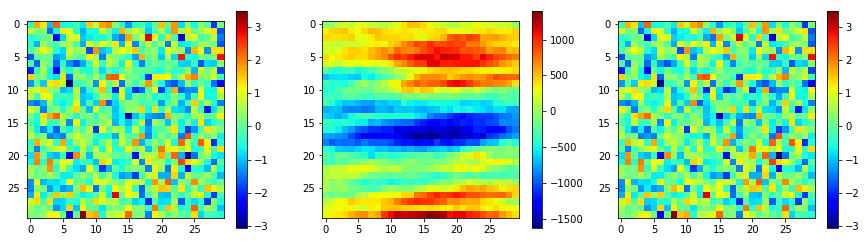

In [19]:
x0 = np.random.normal(size=(1,n)) # random nxn matrix drawn from Gaussian distribution
#x0 = np.ones([1,n])
x = np.dot(x0,L[0])     #transform the random data by the factored covariance matrix to generate spatial correlation
x00 = np.dot(x,Li)      #transform back to random data by multiplying by the inverse of the factored covariance matrix
#-- plot
fig, ax = plt.subplots(1,3,figsize=(15,4))     # Set up figure and subplots
x0_fig = ax[0].imshow(x0.reshape(30,30),cmap='jet')  # Show original random matrix
fig.colorbar(x0_fig,ax=ax[0])                  # Add colorbar
x_fig = ax[1].imshow(x.reshape(30,30),cmap='jet')    # Show transformed random data with spatial correlation
fig.colorbar(x_fig,ax=ax[1])                   # Add colorbar
x00_fig = ax[2].imshow(x00.reshape(30,30),cmap='jet')# Show correlated data transformed back to random data
fig.colorbar(x00_fig,ax=ax[2])                 # Add colorbar
plt.show()

# Spatial Interpolation

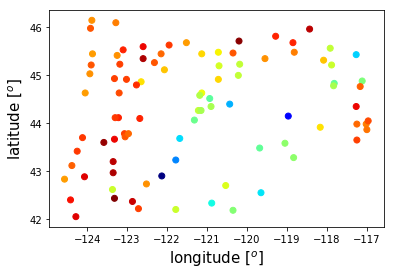

In [4]:
d = pd.read_csv('../Data/oregon_temp_precip.csv')            # Read Oregon data from repository
plt.scatter(d['lon'],d['lat'],c=d['temp_annual'],cmap='jet') # scatter plot, colors based on annual temp
plt.ylabel(r'latitude [$^o$]',fontsize=15)   # y label
plt.xlabel(r'longitude [$^o$]',fontsize=15)  # x label
plt.show()

Optimize variogram parameters

In [ ]:
#-- to be completed

Generate prediction given the variogram

In [ ]:
#-- to be completed

# Spatial Regression

In [5]:
d.head(n=3)     #display the top three rows of the dataset

,station,lat,lon,elevation,temp_jan,temp_jul,temp_annual,precip_jan,precip_jul,precip_ann,county
0,ANT,44.917,-120.717,846,0.0,20.2,9.6,41,9,322,ANTELOPE 1 N USA-OR
1,ARL,45.717,-120.200,96,0.9,24.6,12.5,40,6,228,ARLINGTON USA-OR
2,ASH,42.217,-122.717,543,3.1,20.8,11.1,70,7,480,ASHLAND 1 N USA-OR


In [24]:
robjects.globalenv["precip_ann"] = robjects.FloatVector(d['precip_ann'])  # Add precip to R envrionment 
robjects.globalenv["temp_annual"] = robjects.FloatVector(d['temp_annual'])# Add precip to R envrionment 
robjects.globalenv["lat"] = robjects.FloatVector(d['lat'])                # Add lat to R envrionment
robjects.globalenv["lon"] = robjects.FloatVector(d['lon'])                # Add lon to R envrionment
#-- fit linear regression model while account for spatial autocorrelation 
fit = nlme.gls(r.formula("precip_ann ~ temp_annual"),
               correlation=nlme.corExp(form=r.formula("~lat+lon"),nugget=False),method='ML')  
print r.summary(fit)    # print a summary of the fitted model object

Generalized least squares fit by maximum likelihood
  Model: precip_ann ~ temp_annual 
  Data: NULL 
       AIC      BIC    logLik
  1297.666 1307.753 -644.8329

Correlation Structure: Exponential spatial correlation
 Formula: ~lat + lon 
 Parameter estimate(s):
   range 
6.072546 

Coefficients:
                Value Std.Error   t-value p-value
(Intercept) 1825.4297  711.1956  2.566706  0.0119
temp_annual  -71.6271   20.8419 -3.436694  0.0009

 Correlation: 
            (Intr)
temp_annual -0.303

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-1.2982015 -0.9274755 -0.6598595  0.3166358  1.5576293 

Residual standard error: 917.6314 
Degrees of freedom: 92 total; 90 residual



In [25]:
robjects.globalenv["elevation"] = robjects.FloatVector(d['elevation'])  # Add eleavtion to R envrionment
#-- fit regression model to two parameters
fit2 = nlme.gls(r.formula("precip_ann ~ temp_annual + elevation"), 
                correlation=nlme.corExp(form=r.formula("~lat+lon"),nugget=False),method='ML')   
print r.summary(fit2)     # summary of the fitted model object

Generalized least squares fit by maximum likelihood
  Model: precip_ann ~ temp_annual + elevation 
  Data: NULL 
       AIC      BIC    logLik
  1299.665 1312.273 -644.8323

Correlation Structure: Exponential spatial correlation
 Formula: ~lat + lon 
 Parameter estimate(s):
  range 
6.00687 

Coefficients:
                Value Std.Error   t-value p-value
(Intercept) 1839.7755  834.5722  2.204453  0.0301
temp_annual  -72.8775   40.1626 -1.814559  0.0730
elevation     -0.0087    0.2362 -0.036931  0.9706

 Correlation: 
            (Intr) tmp_nn
temp_annual -0.584       
elevation   -0.526  0.853

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-1.3011053 -0.9242965 -0.6596994  0.3196872  1.5646255 

Residual standard error: 912.847 
Degrees of freedom: 92 total; 89 residual



In [26]:
#-- optimize variogram using fit2 and predict (kriggin)
y = r.predict(fit2)

In [ ]:
#-- plot interpolation

# Model Selection

In [ ]:
robjects.globalenv["y"] = robjects.FloatVector(y)             # Add y to R environment 
robjects.globalenv["x"] = robjects.FloatVector(np.squeeze(x)) # Add x to R environment 
robjects.globalenv["lat"] = robjects.FloatVector(M[:,0])      # Add new lat to R environment
robjects.globalenv["lon"] = robjects.FloatVector(M[:,1])      # Add nwe lon to R environment
    
#-- fit the regression with exponential covariance matrix
fit1 = nlme.gls(r.formula("y ~ x"), 
                correlation=nlme.corExp(form=r.formula("~lat+lon"),nugget=True),method='ML') 
#-- fit the regression with Gaussian covariance matrix
fit2 = nlme.gls(r.formula("y ~ x"), 
                correlation=nlme.corGaus(form=r.formula("~lat+lon"),nugget=True),method='ML') 
#-- display the Bayesian Information Criterion of the fits     
bic = r.BIC(fit1,fit2)
bic_dic = dict(zip(br.names, map(list,list(br)))) # convert to python dictionary
bic_dic['models'] = ['fit1','fit2']               # Add model info
bic_pd = pd.DataFrame(data=bic_dic,columns=np.concatenate([['models'],bic.names])) #make into Pandas DataFrame
bic_pd # Display BIC table

In [ ]:
robjects.globalenv["x2"] = robjects.FloatVector(np.squeeze(x)**2) # Add x^2 to R environment 

#-- fit the single regression with exponential covariance matrix
fit1 = nlme.gls(r.formula("y ~ x"), 
                correlation=nlme.corExp(form=r.formula("~lat+lon"),nugget=True),method='ML') 
#-- fit a two variable regression with exponential covariance matrix 
fit2 = nlme.gls(r.formula("y ~ x + x2"), 
                correlation=nlme.corGaus(form=r.formula("~lat+lon"),nugget=True),method='ML') 
#-- display the Bayesian Information Criterion of the fits     
bic = r.BIC(fit1,fit2)
bic_dic = dict(zip(br.names, map(list,list(br)))) # convert to python dictionary
bic_dic['models'] = ['fit1','fit2']               # Add model info
bic_pd = pd.DataFrame(data=bic_dic,columns=np.concatenate([['models'],bic.names])) #make into Pandas DataFrame
bic_pd # Display BIC table